# k12实践深度学习系列 ：会造假的神经网络

# 无监督学习新方法，生成对抗网络自监督学习（用WGAN神经网络生成人类手写体数字）

# Generative Adversarial Networks (GANs)

在解读WGAN（Wasserstein GAN）之前，必须先理解什么是GANs。GANs本质上是一种生成模型（generative model，简称G），它可以用于生成文本、图像、语音等任何“假”数据（fake data），为了提高“假”数据的质量，GANs引入另一个鉴别模型（discriminator，简称D），来分辨真实数据和“假”数据。生成模型和鉴别模型的持续对抗的过程中，两模型的造“假”和打“假”能力不断提升，“假”数据最终达到以假乱真的效果。这就是生成（Generative）和对抗（Adversarial）的由来。


# GANs的实现过程：

创建两个独立网络：G(创作网络）和 D(鉴别网络),让它们在对抗中不断学习成长。

为D（鉴别网络）创建loss函数，用于训练其区分真实数据和“假”数据，让D网络学会打假。

为G（创作网络）创建loss函数，用于训练其生成出能够骗过D的“假”数据，让G网络学会造假。

<img src="gan.png" width="70%">

# Wasserstein GAN （WGAN）

WGAN新算法是传统GAN训练的替代方法。用这个新模型完成生成对抗网络任务，可以提高神经网络学习的稳定性，摆脱模式崩溃之类的问题，并提供有意义的学习曲线，方便调试和超参数搜索。

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.vision.gan import *

## 创建手写体数字的数据集

本节课，我们将使用`MNIST`的手写体数据集。整个数据集略大，因此这里我们只用`MNIST_SAMPLE`节选数字3和7的手写体数据来模仿。

In [4]:
# path = untar_data(URLs.MNIST_SAMPLE); path
path = Path('mnist_sample');path

PosixPath('mnist_sample')

预处理训练数据：我们使用data block API抓取所有图片到文件夹中。我们不会创建一个独立验证集，后面会做解释。输入数据里包含了均值为100的随机噪声，并将手写体数字的图片作为目标。

In [5]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none() 
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

创建bs=32,size=16的Dataset和Dataloader

In [6]:
data = get_data(32, 16)

In [14]:
len(data.train_dl)*32

14432

In [8]:
len(data.train_ds)

14434

In [18]:
data.valid_ds

LabelList (0 items)
x: GANItemList

y: ImageList

Path: mnist_sample

In [19]:
data.train_ds

LabelList (14434 items)
x: GANItemList
,,,,
y: ImageList
Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16),Image (3, 16, 16)
Path: mnist_sample

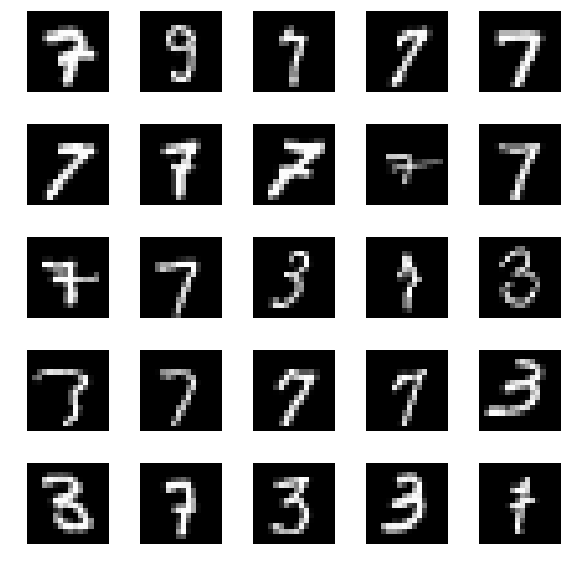

In [9]:
data.show_batch(rows=5,figsize=(8,8))

## 创建Models模型

GAN即生成对抗网络心概念是同时训练两个模型：一个生成器网络和一个评判网络。生成器网络将自创和数据集中的图片相似的新图片，而评判网络则试图从生成器生成的图片中分辨出真实的图片。生成器给出图片，评判网络则输出一个（作为评判结果的）值（通常0表示赝品,1表示真品）。

这两个网络每一步都在做对抗训练，就像在打乒乓球你来我往，我们如下这样操做：

1. 冻结创作网络，训练鉴别网络:
  - 获取一批真品图片(我们简称为`真`)
  - 产生一批赝品图片(我们简称为`假`)
  - 让鉴别网络评估这批数据并计算出损失函数值；重要的一点是，如果判断出真假就要给与奖励，反之，则予以惩罚。
  - 使用损失函数的梯度来更新鉴别网络的权重

2. 冻结鉴别网络，训练创作网络：
  - 产生一批赝品图片
  - 鉴别网络对这些图片进行评判
  - 返回损失（函数），这是评判网络得到的所有真实图片的回馈，它的重要作用是，探测出为真实图片欺骗成功就给予奖励,反之则给予惩罚
  - 使用损失函数的梯度来更新创作网络的权重

<img src="gan.png" width="40%">

这里,我们将使用[Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf)这篇论文中的GAN网络。

我们将创建一个生成器创作网络和一个评判鉴别网络，把他们作为参数传给`gan_learner`。

创建创作网络 G

In [10]:
generator = basic_generator(in_size=16, n_channels=3, n_extra_layers=1)

创建鉴别网络 D

In [11]:
critic = basic_critic(in_size=16, n_channels=3, n_extra_layers=1)

我们将生成器创作网络G和评判鉴别网络D作为参数传给`gan_learner`,创建一个wgan网络。

In [12]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

训练wgan网络

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.272461,#na#,0.164731,-0.364902,00:31
1,-0.249385,#na#,0.159778,-0.331449,00:26
2,-0.253382,#na#,0.156766,-0.333972,00:25
3,-0.243803,#na#,0.152872,-0.319916,00:26
4,-0.179064,#na#,0.124986,-0.235279,00:26


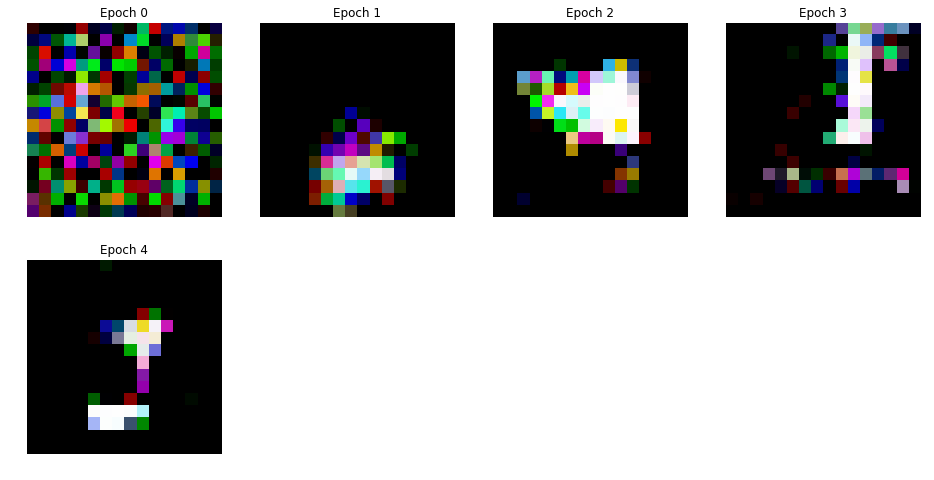

In [13]:
learn.fit(5,2e-4)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.267383,#na#,0.163779,-0.358374,00:25
1,-0.249058,#na#,0.156861,-0.330538,00:24
2,-0.251741,#na#,0.155494,-0.332117,00:24
3,-0.240912,#na#,0.151434,-0.316421,00:24
4,-0.157161,#na#,0.119594,-0.205941,00:25
5,-0.117774,#na#,0.092566,-0.161695,00:25
6,-0.104487,#na#,0.080093,-0.142379,00:25
7,-0.101917,#na#,0.066924,-0.133676,00:27
8,-0.091747,#na#,0.071565,-0.124951,00:26
9,-0.085642,#na#,0.069199,-0.114922,00:26


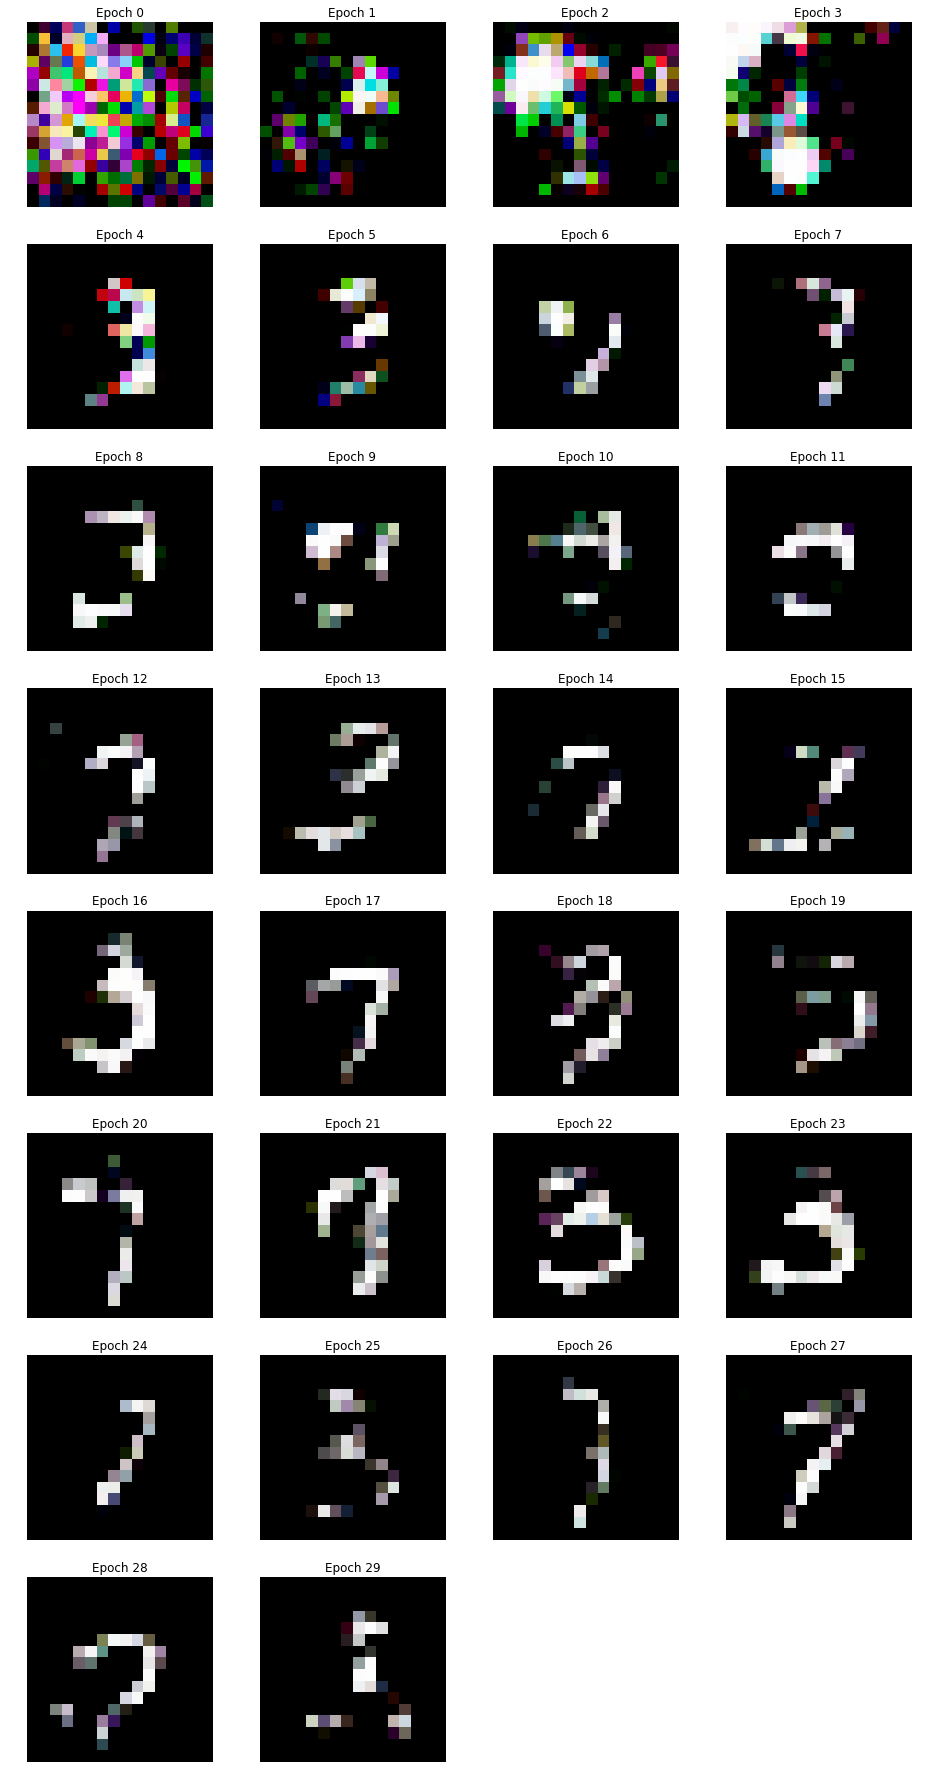

In [53]:
# learn.fit(30,2e-4)

In [16]:
# learn.save('wgan_37')

In [16]:
learn.load('wgan_37');learn.summary()

GANModule
Layer (type)         Output Shape         Param #    Trainable 
ConvTranspose2d      [128, 4, 4]          204,800    True      
______________________________________________________________________
ReLU                 [128, 4, 4]          0          False     
______________________________________________________________________
BatchNorm2d          [128, 4, 4]          256        True      
______________________________________________________________________
ConvTranspose2d      [64, 8, 8]           131,072    True      
______________________________________________________________________
ReLU                 [64, 8, 8]           0          False     
______________________________________________________________________
BatchNorm2d          [64, 8, 8]           128        True      
______________________________________________________________________
ConvTranspose2d      [64, 8, 8]           36,864     True      
____________________________________________________

## 评估模型训练效果

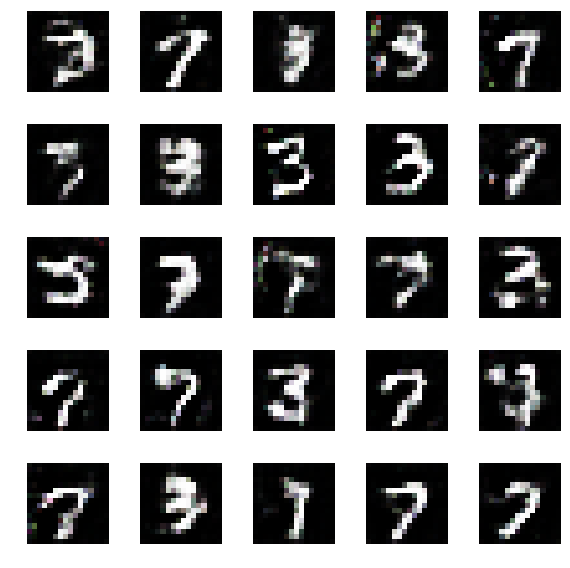

In [17]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=None, rows=5, figsize=(8,8))